# Exploring and Evaluating Trading Models for MetaTrader

**Author**: Roy Meshulam

This notebook is dedicated to examining different trading models for use in MetaTrader, a popular trading platform. By leveraging data analysis, feature engineering, and machine learning techniques, we aim to develop and evaluate predictive models that can assist in identifying profitable trading opportunities.

---

## Objectives

- **Data Exploration**: Perform detailed exploratory data analysis (EDA) to uncover trends and patterns in historical trading data.
- **Feature Engineering**: Create and preprocess features that capture market dynamics, such as technical indicators (e.g., RSI, MACD, Moving Averages).
- **Model Selection**: Test and compare different machine learning models to predict market movements (e.g., Buy or Sell signals).
- **Performance Evaluation**: Evaluate models based on key metrics such as accuracy, precision, recall, F1-score, and profit/loss simulations.
- **Backtesting**: Integrate selected models with a MetaTrader-compatible backtesting environment to simulate trading outcomes.

---

## Workflow

1. **Data Preparation**:
   - Import trading data from MetaTrader or other sources.
   - Clean and preprocess the data (e.g., handle missing values, normalize numerical features).
   
2. **Feature Engineering**:
   - Generate technical indicators (e.g., RSI, MACD, SMA, ATR).
   - Engineer additional features like gaps, volatility, or sentiment scores (if available).

3. **Model Building**:
   - Test different machine learning algorithms such as Logistic Regression, Random Forest, Gradient Boosting, or Neural Networks.
   - Tune hyperparameters to optimize performance.

4. **Evaluation**:
   - Use cross-validation and out-of-sample testing to assess model reliability.
   - Compare performance across multiple metrics and select the best model for deployment.

5. **Backtesting**:
   - Simulate trading strategies using the selected model(s).
   - Analyze profitability, drawdowns, and win rates.

---

## Expected Outcomes

- Identification of the best-performing trading model(s) based on historical data.
- Insights into which features and strategies yield the most reliable results.
- A ready-to-deploy model that integrates seamlessly with MetaTrader for live trading or further testing.

---

## Tools and Libraries

- **Python Libraries**:
  - `pandas`, `numpy`: For data manipulation and analysis.
  - `scikit-learn`, `xgboost`: For machine learning model development.
  - `matplotlib`, `seaborn`: For data visualization.
- **MetaTrader Integration**:
  - Data export/import via MQL scripts or APIs.
  - Backtesting and evaluation using MetaTrader's Strategy Tester.

---

## How to Use This Notebook

- Download MetaTrader2CSV.ex4 from https://www.roymeshulam.com/projects.
- Inside MetaTrader 4, attach this expert advisor to a symbol of your choice and choose start date, end date and timeframe.
- Use the generated file with this notebook.
- Ensure you have access to historical trading data in a format compatible with the notebook (e.g., CSV or directly from MetaTrader).
- Follow the cells sequentially to preprocess the data, build models, and evaluate performance.
- Customize feature engineering or models based on your specific trading strategy or asset class.

---

Let's dive in and explore the world of trading model development! 🚀

## Prerequisites

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.compose  import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression, LinearRegression


## Loading the Data
- Loading the data from the CSV file created by MetaTrader expert advisor https://www.roymeshulam.com/projects

In [2]:
df = pd.read_csv("GBPUSD-metatrader.csv") 
print(f'Data shape: {df.shape}') 
print(df.head())


Data shape: (779, 8)
         Date      ATR    RSI  MACD_LINE  MACD_SIGNAL     SMA5    SMA20  \
0  2022.01.03  0.00797  64.59    0.00309     -0.00112  1.34761  1.33203   
1  2022.01.04  0.00788  58.73    0.00340     -0.00010  1.34832  1.33311   
2  2022.01.05  0.00792  62.39    0.00402      0.00085  1.35027  1.33455   
3  2022.01.06  0.00789  64.19    0.00467      0.00171  1.35163  1.33633   
4  2022.01.07  0.00745  61.70    0.00496      0.00250  1.35231  1.33790   

   BuySell  
0        1  
1        0  
2        0  
3        1  
4        0  


## Removing Missing Values
- Removing lines with missing values.
- Printing the number of lines removed.
- Printing the final data size after cleanup.

In [3]:
print(f'Data shape with missing values: {df.shape}')

df.replace(' ', pd.NA, inplace=True)
na_count = df.isna().sum(axis=1).gt(0).sum()
df.dropna(inplace=True)

print(f'Number of rows with NA values: {na_count}')
print(f'Data shape without missing values: {df.shape}')

Data shape with missing values: (779, 8)
Number of rows with NA values: 0
Data shape without missing values: (779, 8)


## Grouping Features

- Creating lists containing the names of the numerical and categorical features.
- Printing these lists along with messages indicating which features are numerical and which are categorical.

In [4]:
num_features = df.columns[1:-1].tolist()
print('Numerical Features:',len(num_features))
print(num_features)

Numerical Features: 6
['ATR', 'RSI', 'MACD_LINE', 'MACD_SIGNAL', 'SMA5', 'SMA20']


## Removing Outliers
- Identifying outliers using IQR.
- Remove outlier lines.
- Printing the number of lines removed.
- Printing the final data size after removal.

In [5]:
print(f'df shape with outliers: {df.shape}')

# Loop through each numerical feature and clean outliers
for feature in num_features:
    df[feature] = pd.to_numeric(df[feature], errors='coerce')
    df = df.dropna()
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    df = df[~df.index.isin(outliers.index)]
    print(f"Number of outliers removed from {feature}: {len(outliers)}")

print(f'df shape without outliers: {df.shape}')

df shape with outliers: (779, 8)
Number of outliers removed from ATR: 45
Number of outliers removed from RSI: 0
Number of outliers removed from MACD_LINE: 0
Number of outliers removed from MACD_SIGNAL: 0
Number of outliers removed from SMA5: 18
Number of outliers removed from SMA20: 2
df shape without outliers: (714, 8)


## Label Distribution
- Using `value_counts()` to display the distribution of the label values as proportions.

In [6]:
print(df.BuySell.value_counts(normalize=True))

BuySell
0    0.530812
1    0.469188
Name: proportion, dtype: float64


## df Plots
The project must contain charts and graphs, statistically describing the data features.
At a minimum include a:
- Box (or Violin) and Whisker plot of data features
- Scree plot of primary components
- Scatter plot of the data
- Bivariate plots between key feature

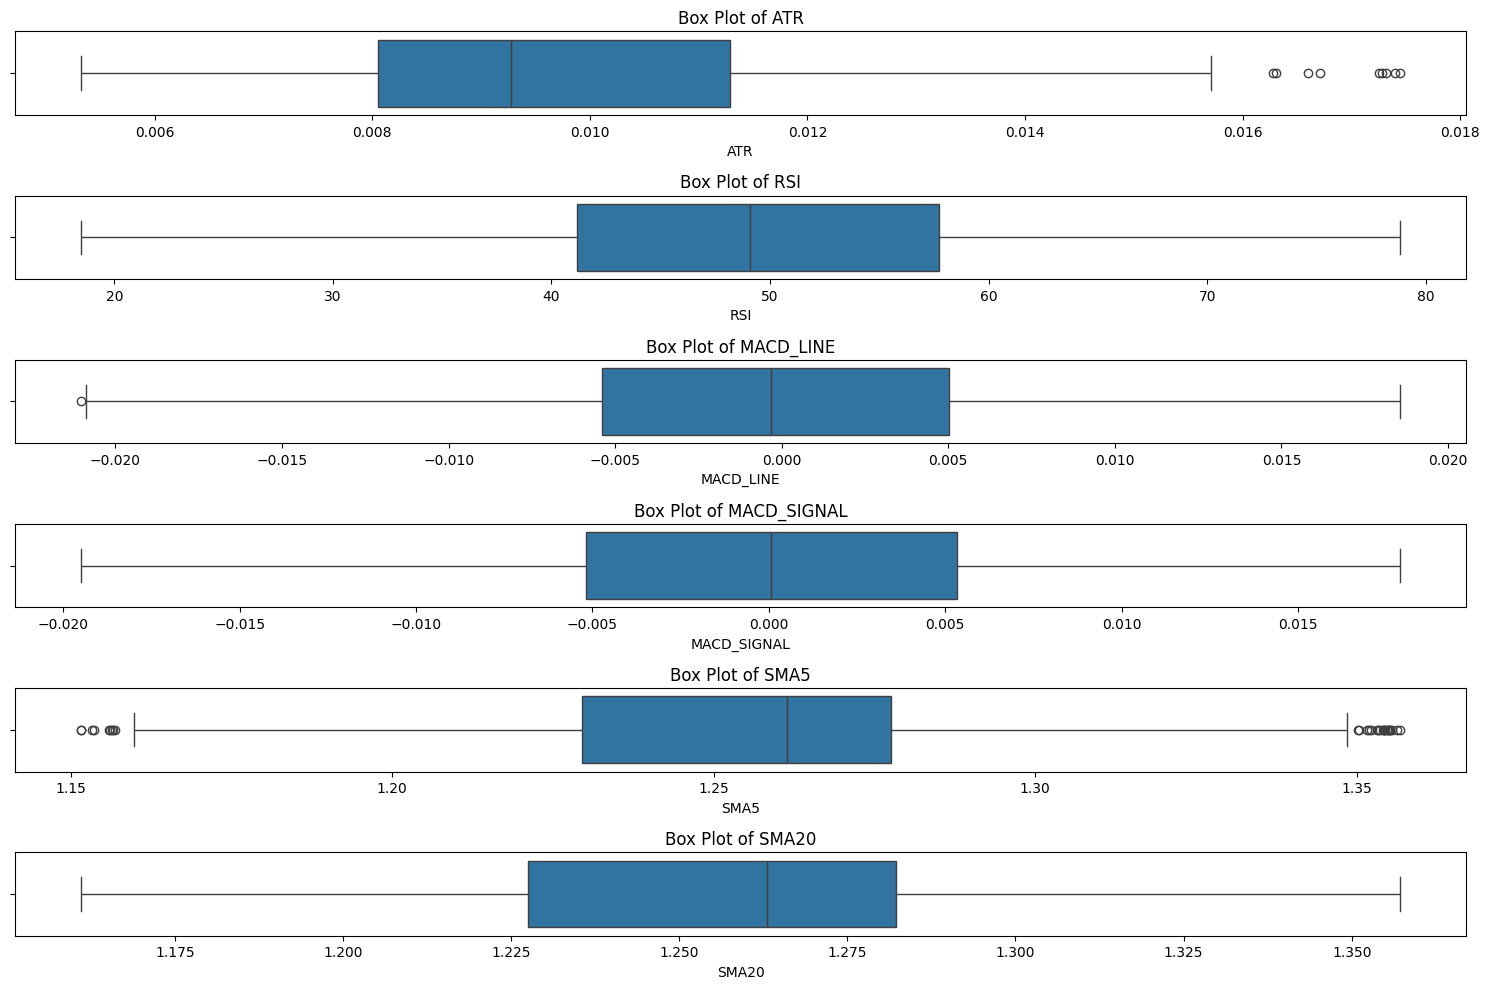

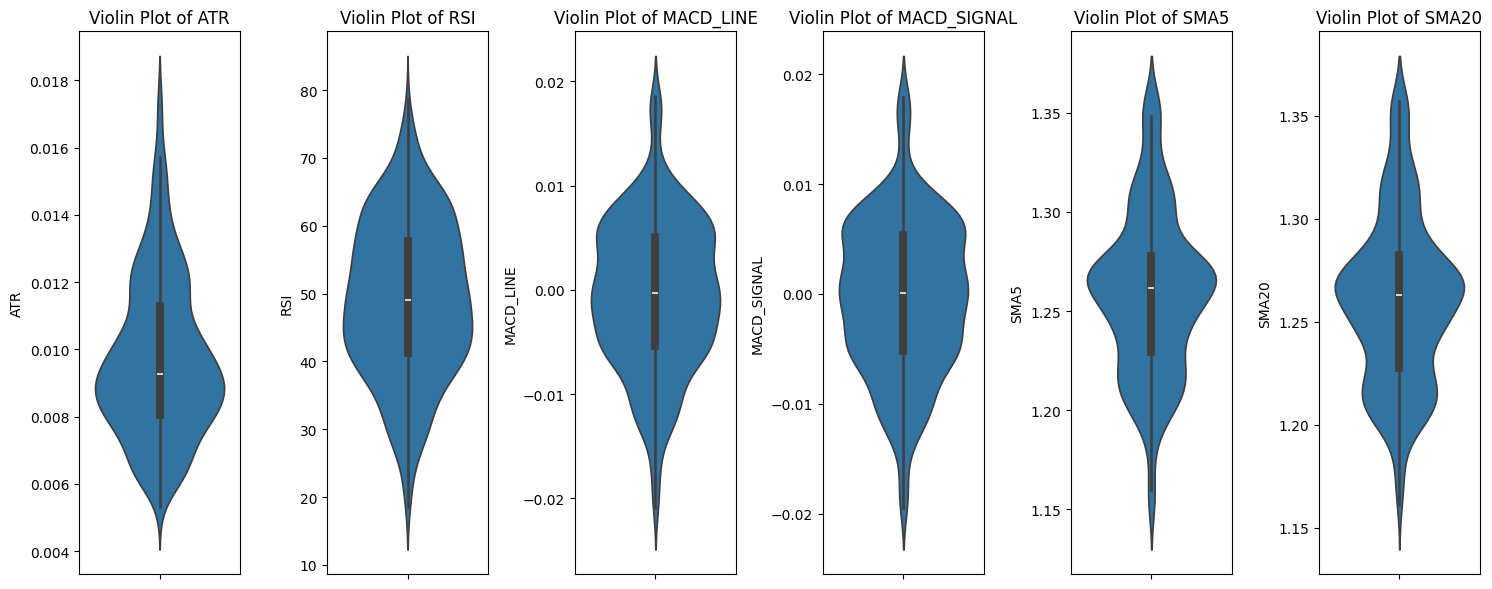

<Figure size 1000x600 with 0 Axes>

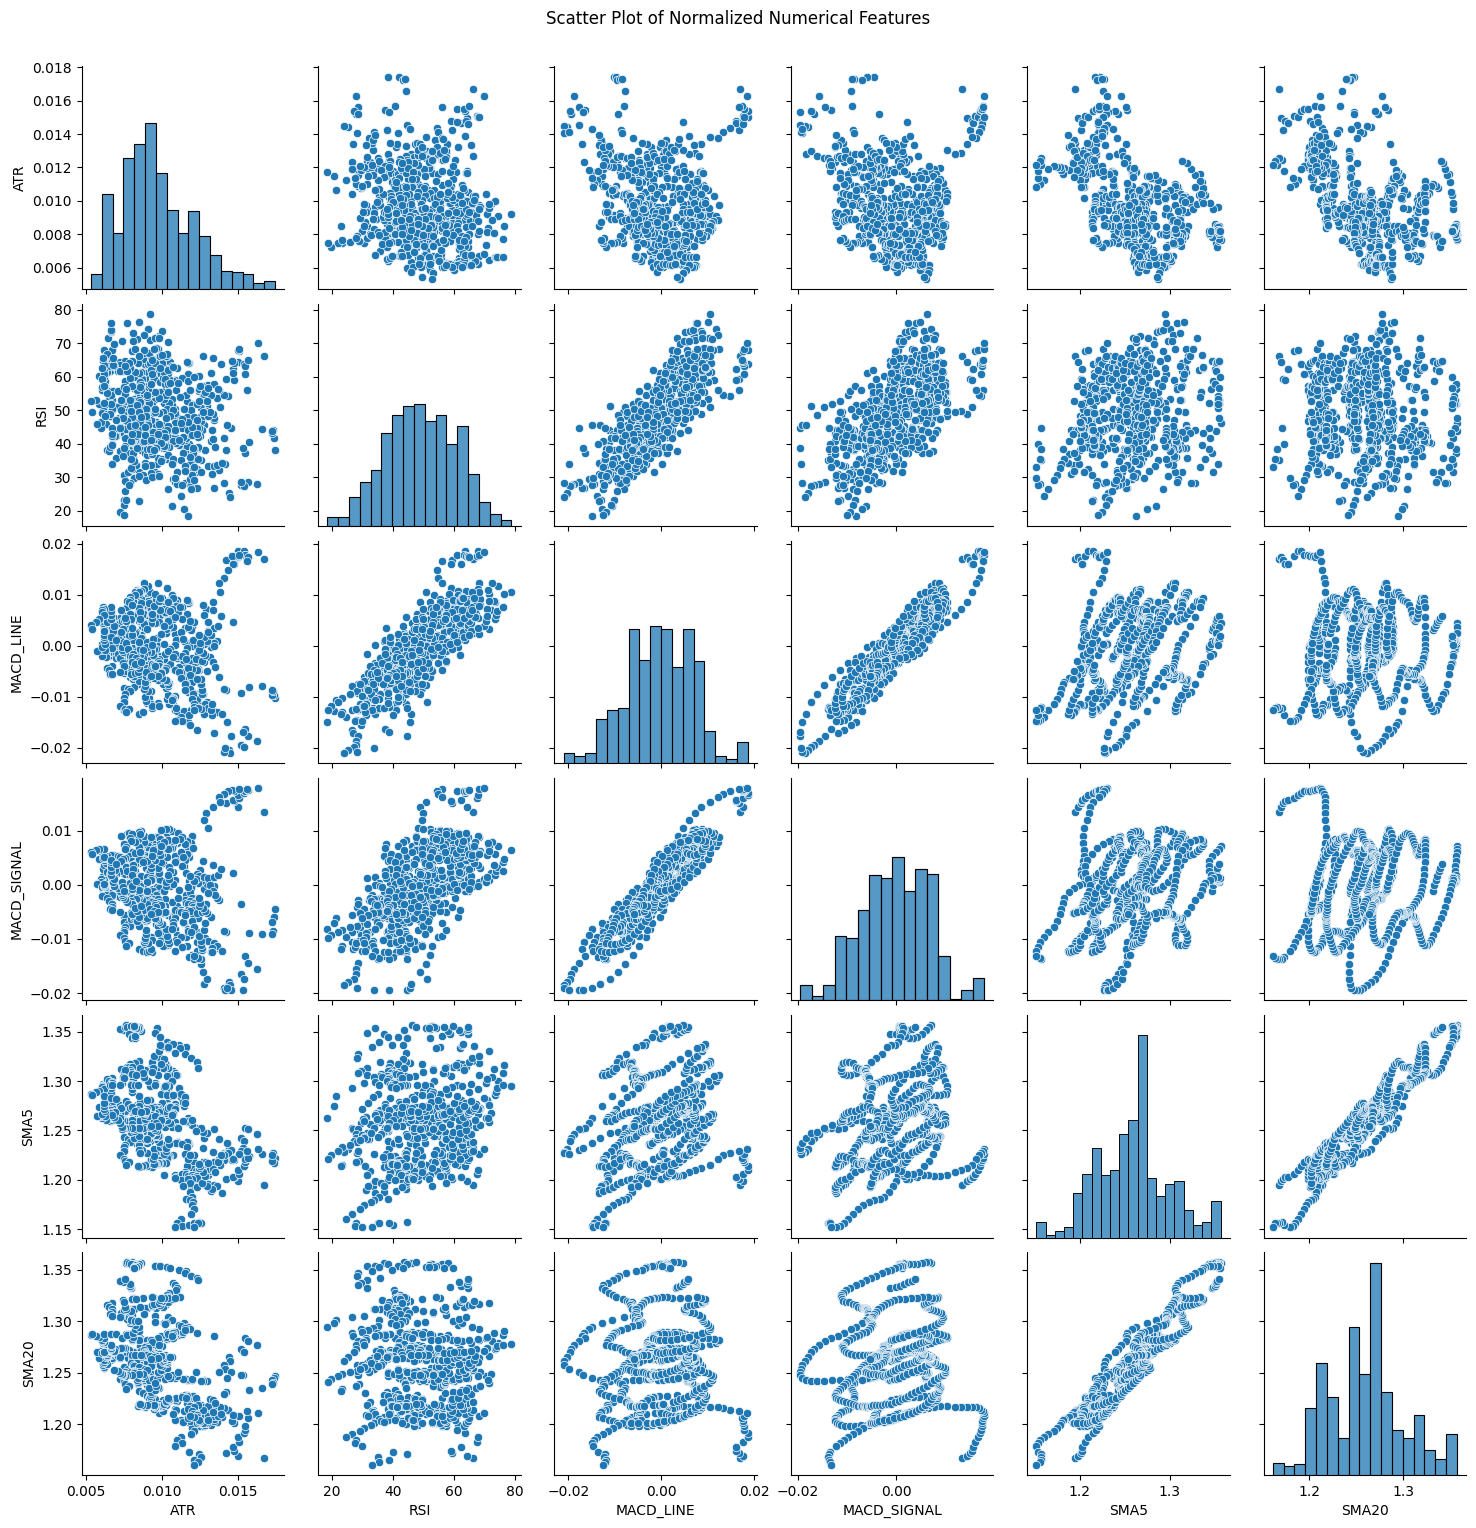

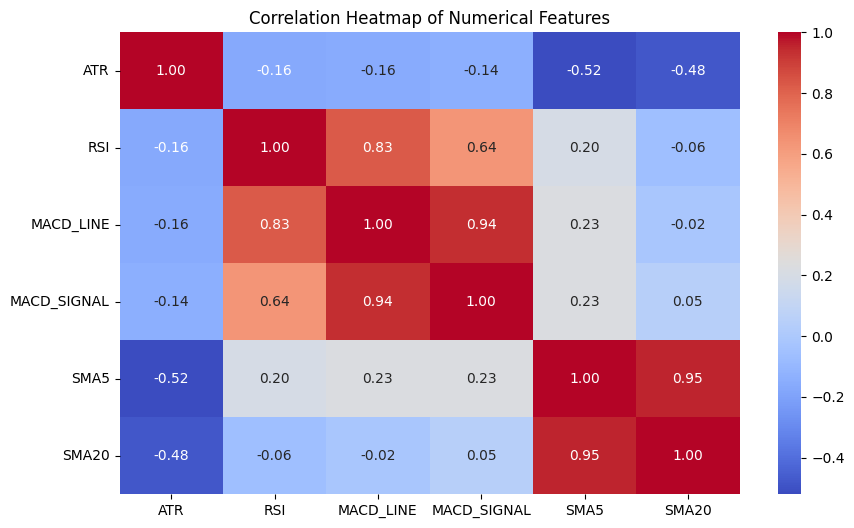

In [7]:
# Box plot of normalized numerical features as subplots
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
for i, feature in enumerate(num_features):
    plt.subplot(len(num_features), 1, i + 1)  # Create a subplot for each feature
    sns.boxplot(data=df, x=feature)
    plt.title(f'Box Plot of {feature}')
    plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Violin plot of normalized numerical features side by side
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed

for i, feature in enumerate(num_features):
    plt.subplot(1, len(num_features), i + 1)  # Create a subplot for each feature in a single row
    sns.violinplot(data=df, y=feature)  # Use 'y' for vertical orientation
    plt.title(f'Violin Plot of {feature}')
    plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Scatter plot of normalized numerical features
plt.figure(figsize=(10, 6))
sns.pairplot(df[num_features])
plt.suptitle('Scatter Plot of Normalized Numerical Features', y=1.02)
plt.show()

# Correlation heatmap of numerical features
plt.figure(figsize=(10, 6))
correlation_matrix = df[num_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

## Generating Training Sets
- Using train_test_split() to split the data into training sets using an 80/20 split.
- Naming the resulting arrays X_train, y1_train

In [8]:
X = np.array(df[num_features])
y = np.array(df['BuySell'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(f'Training Features Shape: {X_train.shape}')
print(f'Test Features Shape:     {X_test.shape}')

Training Features Shape: (571, 6)
Test Features Shape:     (143, 6)


## Data Preprocessing

- Creating instances of `StandardScaler` and `OneHotEncoder`
- Using them to create an instance of `ColumnTransformer`
- Applying each preprocessing object to the appropriate columns.
- Fitting and applying `ColumnTransformer` to the DataFrame containing the data.
- Storing the resulting feature array in a variable.
- Printing the shape of the final feature array.

In [9]:
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers = [
        ('sca', scaler, num_features)
    ]
)

# Ensure X_train and X_test are DataFrames before applying the preprocessor
X_train_df = pd.DataFrame(X_train, columns=df[num_features].columns)
X_test_df = pd.DataFrame(X_test, columns=df[num_features].columns)

X_train = preprocessor.fit_transform(X_train_df)
X_test = preprocessor.transform(X_test_df)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Y shape: {y.shape}')

X_train shape: (571, 6)
X_test shape: (143, 6)
Y shape: (714,)


## Logistic Regression
- Using logistic regression to predict the target value

In [10]:
lor_mod = LogisticRegression(random_state=1)
lor_mod.fit(X_train, y_train)

print('Logistic Regression Results:')
train_acc_LoR = round(lor_mod.score(X_train, y_train) * 100, 2)
test_acc_LoR = round(lor_mod.score(X_test, y_test) * 100, 2)
print(f'Logistic Regression Training Accuracy: {round(train_acc_LoR,4)}')
print(f'Logistic Regression Testing Accuracy:  {round(test_acc_LoR,4)}')

test_pred = lor_mod.predict(X_test)

cm = confusion_matrix(y_test, test_pred)
print('\n- Confusion Matrix:')
print(pd.DataFrame(cm, index=['No', 'Yes'], columns=['No', 'Yes'] ))

print('\n- Classification Report:')
print(classification_report(y_test, test_pred))

Logistic Regression Results:
Logistic Regression Training Accuracy: 53.59
Logistic Regression Testing Accuracy:  56.64

- Confusion Matrix:
     No  Yes
No   63   19
Yes  43   18

- Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.77      0.67        82
           1       0.49      0.30      0.37        61

    accuracy                           0.57       143
   macro avg       0.54      0.53      0.52       143
weighted avg       0.55      0.57      0.54       143



## Linear Regression
- Using linear regression to predict the target value

In [11]:
lir_mod = LinearRegression()
lir_mod.fit(X_train, y_train)

print('Linear Regression Results:')
train_acc_LiR = round(lir_mod.score(X_train, y_train) * 100, 2)
test_acc_LiR = round(lir_mod.score(X_test, y_test) * 100, 2)
print(f'Linear Regression Training Accuracy: {round(train_acc_LiR,4)}')
print(f'Linear Regression Testing Accuracy:  {round(test_acc_LiR,4)}')


test_pred = lir_mod.predict(X_test)
test_pred_binary = np.where(test_pred >= 0.5, 1.0, 0.0)

cm = confusion_matrix(y_test, test_pred_binary)
print('\n- Confusion Matrix:')
print(pd.DataFrame(cm, index=['No', 'Yes'], columns=['No', 'Yes'] ))

print('\n- Classification Report:')
print(classification_report(y_test, test_pred_binary))

Linear Regression Results:
Linear Regression Training Accuracy: 0.46
Linear Regression Testing Accuracy:  0.22

- Confusion Matrix:
     No  Yes
No   62   20
Yes  43   18

- Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.76      0.66        82
           1       0.47      0.30      0.36        61

    accuracy                           0.56       143
   macro avg       0.53      0.53      0.51       143
weighted avg       0.54      0.56      0.54       143



## Neural Network
- Using MLPClassifier to predict the target value

In [12]:
nn = MLPClassifier(max_iter=1000, random_state=1, hidden_layer_sizes=(100,))
nn.fit(X_train, y_train)

print('Neural Network Results:')
train_acc_NN = round(nn.score(X_train, y_train) * 100, 2)
test_acc_NN = round(nn.score(X_test, y_test) * 100, 2)
print(f'Neural Network Classifier Training Accuracy: {round(train_acc_NN,4)}')
print(f'Neural Network Classifier Testing Accuracy:  {round(test_acc_NN,4)}')

test_pred = nn.predict(X_test)

cm = confusion_matrix(y_test, test_pred)
print('\n- Confusion Matrix:')
print(pd.DataFrame(cm, index=['No', 'Yes'], columns=['No', 'Yes'] ))

print('\n- Classification Report:')
print(classification_report(y_test, test_pred))

Neural Network Results:
Neural Network Classifier Training Accuracy: 67.95
Neural Network Classifier Testing Accuracy:  55.94

- Confusion Matrix:
     No  Yes
No   55   27
Yes  36   25

- Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.67      0.64        82
           1       0.48      0.41      0.44        61

    accuracy                           0.56       143
   macro avg       0.54      0.54      0.54       143
weighted avg       0.55      0.56      0.55       143



c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


## Random Forest Models

Optimal value for max_depth: 13


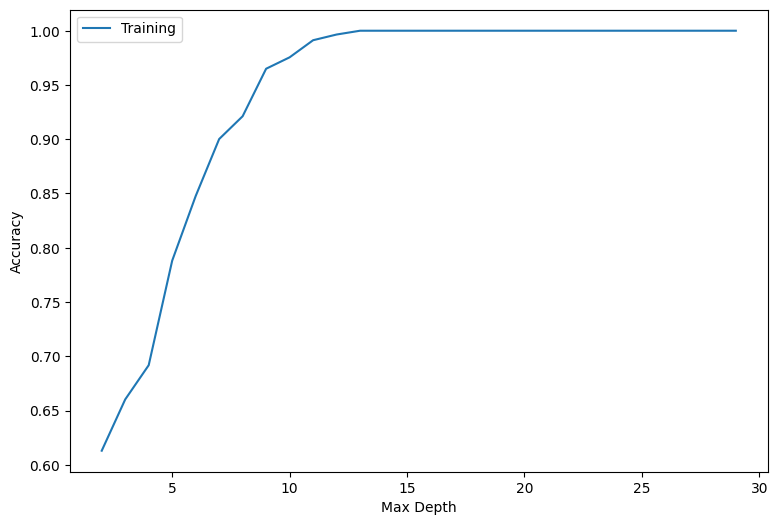

In [13]:
# 1. Creating empty list named rf_train_acc to store the accuracy scores that we calculate for each model.
rf_train_acc = []

# 2. Looping over the values in depth_range to find the optimal tree depth
depth_range = range(2,30)
for d in depth_range:
    np.random.seed(1)
    temp_forest = RandomForestClassifier(n_estimators=100, max_depth=d, random_state=1, min_samples_leaf=1, max_features='sqrt')
    temp_forest.fit(X_train, y_train)
    rf_train_acc.append(temp_forest.score(X_train, y_train))

# 3. Using np.argmax to determine the index of the maximum value in rf_test_acc. Storing the result in rf_idx.
rf_idx = np.argmax(rf_train_acc)

# 4. Using rf_idx and depth_range to find the optimal value for the max_depth hyperparameter.
rf_opt_depth = depth_range[rf_idx]
print(f'Optimal value for max_depth: {rf_opt_depth}')

plt.figure(figsize=([9, 6]))
plt.plot(depth_range, rf_train_acc, label='Training')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
optimal_forest = RandomForestClassifier(n_estimators=100, max_depth=d, random_state=1, min_samples_leaf=1, max_features='sqrt')
optimal_forest.fit(X_train, y_train)

print('Random Forest Results:')
train_acc_RF = round(optimal_forest.score(X_train, y_train) * 100, 2)
test_acc_RF = round(optimal_forest.score(X_test, y_test) * 100, 2)
print(f'Random Forest Classifier Training Accuracy: {round(train_acc_RF,4)}')
print(f'Random Forest Classifier Testing Accuracy:  {round(test_acc_RF,4)}')

test_pred = optimal_forest.predict(X_test)

cm = confusion_matrix(y_test, test_pred)
print('\n- Confusion Matrix:')
print(pd.DataFrame(cm, index=['No', 'Yes'], columns=['No', 'Yes'] ))

print('\n- Classification Report:')
print(classification_report(y_test, test_pred))

Random Forest Results:
Random Forest Classifier Training Accuracy: 100.0
Random Forest Classifier Testing Accuracy:  62.24

- Confusion Matrix:
     No  Yes
No   56   26
Yes  28   33

- Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.67        82
           1       0.56      0.54      0.55        61

    accuracy                           0.62       143
   macro avg       0.61      0.61      0.61       143
weighted avg       0.62      0.62      0.62       143



## XGBOOST

Optimal value for max_depth: 5


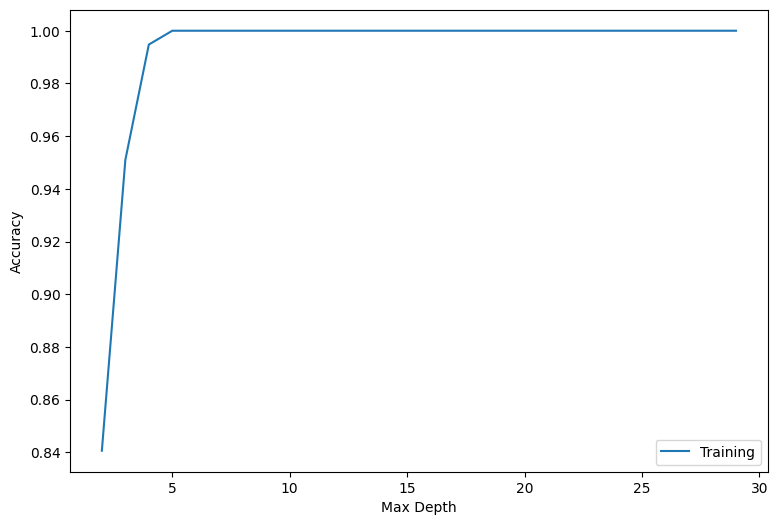

In [15]:
# 1. Creating empty list named xgb_train_acc to store the accuracy scores that we calculate for each model.
xgb_train_acc = []

# 2. Looping over the values in depth_range to find the optimal tree depth
depth_range = range(2, 30)
for d in depth_range:
    np.random.seed(1)
    temp_boost = xgb.XGBClassifier(n_estimators=100, max_depth=d, random_state=1, min_child_weight=1, colsample_bytree=0.8)
    temp_boost.fit(X_train, y_train)
    xgb_train_acc.append(temp_boost.score(X_train, y_train))

# 3. Using np.argmax to determine the index of the maximum value in xgb_train_acc. Storing the result in xgb_idx.
xgb_idx = np.argmax(xgb_train_acc)

# 4. Using xgb_idx and depth_range to find the optimal value for the max_depth hyperparameter.
xgb_opt_depth = depth_range[xgb_idx]
print(f'Optimal value for max_depth: {xgb_opt_depth}')

plt.figure(figsize=([9, 6]))
plt.plot(depth_range, xgb_train_acc, label='Training')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
optimal_boosted_forest = xgb.XGBClassifier(n_estimators=100, max_depth=xgb_opt_depth, random_state=1, min_child_weight=1, colsample_bytree=0.8)
optimal_boosted_forest.fit(X_train, y_train)

print('Boosted Random Forest Results:')
train_acc_BRF = round(optimal_boosted_forest.score(X_train, y_train) * 100, 2)
test_acc_BRF = round(optimal_boosted_forest.score(X_test, y_test) * 100, 2)
print(f'Boosted Random Forest Classifier Training Accuracy: {round(train_acc_BRF,4)}')
print(f'Boosted Random Forest Classifier Testing Accuracy:  {round(test_acc_BRF,4)}')

test_pred = optimal_boosted_forest.predict(X_test)
cm = confusion_matrix(y_test, test_pred)
print('\n- Confusion Matrix:')
print(pd.DataFrame(cm, index=['No', 'Yes'], columns=['No', 'Yes'] ))

print('\n- Classification Report:')
print(classification_report(y_test, test_pred))

Boosted Random Forest Results:
Boosted Random Forest Classifier Training Accuracy: 100.0
Boosted Random Forest Classifier Testing Accuracy:  56.64

- Confusion Matrix:
     No  Yes
No   51   31
Yes  31   30

- Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        82
           1       0.49      0.49      0.49        61

    accuracy                           0.57       143
   macro avg       0.56      0.56      0.56       143
weighted avg       0.57      0.57      0.57       143



## Models Comparison

In [17]:
models = pd.DataFrame({
    'Model': ['Random Forest', 'Neural Netrwork', 'Boosted Random Forest', 'Logistic Regression', 'Linear Regression'],
    'Train Score': [train_acc_RF, train_acc_NN, train_acc_BRF, train_acc_LoR, train_acc_LiR],
    'Test Score': [test_acc_RF, test_acc_NN, test_acc_BRF, test_acc_LoR, test_acc_LiR]
    })
models=models.sort_values(by='Test Score', ascending=False)
print(models)

                   Model  Train Score  Test Score
0          Random Forest       100.00       62.24
2  Boosted Random Forest       100.00       56.64
3    Logistic Regression        53.59       56.64
1        Neural Netrwork        67.95       55.94
4      Linear Regression         0.46        0.22
